This is a simple notebook to process the COVID-19 CT images.

1. Load a lung 3D CT scan
2. Plot a selected 2D slice
3. Normalise image intensities: 
    1. stretch intensity values distribution using percentiles
    2. standardise around mean value
    3. rescale [0-255]
4. Mask the body: 
    1. region growing
    2. morphological operations 
    3. connected components
5. Mask the lung: 
    1. threshold
    2. morphological operations 
    3. connected components

In [4]:
import os
import numpy as np
import SimpleITK as sitk
from psutil import cpu_count
from operator import sub

num_threads = cpu_count(logical=False)
print(' Set number of threads to ', num_threads)
os.environ["OMP_NUM_THREADS"] = str(num_threads)
os.environ['ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS'] = str(num_threads)
sitk.ProcessObject.SetGlobalDefaultNumberOfThreads(num_threads)
                                                   

 Set number of threads to  8


## Load images

In [5]:
# Read nifti
data_dir = '/Users/amiralansary/PycharmProjects/covid-19/data/nifti'
pimage_path = os.path.join(data_dir, 'Positive/Case_003/Case_003_Chest_Helical_0_203.nii.gz')
nimage_path = os.path.join(data_dir, 'Negative/CT-Training-BE010/5-HIGH-RES-86.27_STANDARD_CHEST_PROTOCOL_Thorax_20070427154248_5.nii.gz')
pimage_sitk = sitk.ReadImage(pimage_path)
nimage_sitk = sitk.ReadImage(nimage_path)
selected_image = pimage_sitk

In [6]:
## read dicom
# reader = sitk.ImageSeriesReader()
# data_dir = '/Users/amiralansary/Downloads/covid-19'
# 
# # read a positive case
# pimage_path = os.path.join(data_dir, 'Positive/Case_002/')
# dicom_names = reader.GetGDCMSeriesFileNames(pimage_path)
# reader.SetFileNames(dicom_names)
# pimage_sitk = reader.Execute()
# 
# nimage_path = os.path.join(data_dir, 'Negative/CT-Training-BE006/01-09-2007-6824-CT INFUSED CHEST-407.1/4-HIGH RES-86.17')
# dicom_names = reader.GetGDCMSeriesFileNames(nimage_path)
# reader.SetFileNames(dicom_names)
# nimage_sitk = reader.Execute()

# selected_image = nimage_sitk

In [7]:
# print header information
# print(image_sitk)
print(pimage_sitk.GetSize())
print(nimage_sitk.GetSize())

# Extract the 3d image (numpy) array from (sitk) image file
pimage_array = sitk.GetArrayFromImage(pimage_sitk)
nimage_array = sitk.GetArrayFromImage(nimage_sitk)

(512, 512, 200)
(512, 512, 353)


## Plot a selected 2D slides


In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'negative case')

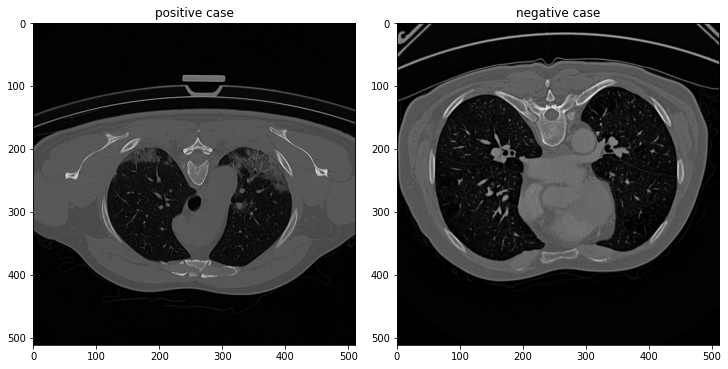

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10,20), facecolor='w', edgecolor='k', constrained_layout=True)

axs[0].imshow(pimage_array[150,:,:], cmap='gray')
axs[0].set_title('positive case')# show slide number 100

axs[1].imshow(nimage_array[150,:,:], cmap='gray')
axs[1].set_title('negative case')

## Normalise image intensity

In [10]:
# normalise images
def normalise_image(image_sitk):
    # suppress an pixel less than 20-percentile to be a background and vice versa
    volOrg  = sitk.GetArrayFromImage(image_sitk)
    pixels = volOrg.ravel()
    q20 = np.quantile(pixels,0.2)
    q90 = np.quantile(pixels,0.9)
    norm_image = sitk.Clamp(image_sitk, lowerBound=q20, upperBound=q90)
    norm_image = (norm_image - pixels.mean()) / pixels.std()
    return sitk.RescaleIntensity(norm_image)

norm_image_sitk = normalise_image(selected_image)
# save normalised image
sitk.WriteImage(norm_image_sitk, 'norm_image.nii.gz')

print('Normalisation done')

Normalisation done


## Mask body

In [11]:
# smooth image 
smooth_image_sitk = sitk.SmoothingRecursiveGaussian(norm_image_sitk,2.)
# save temporary files
sitk.WriteImage(smooth_image_sitk, 'smooth_image.nii.gz')
# select seed point in the background 
seed = smooth_image_sitk.GetSize()
seed = tuple(map(sub, seed, (1,1,1)))
# region growing from the seed point
seg_con = sitk.ConnectedThreshold(smooth_image_sitk, seedList=[seed], lower=-1, upper=100)
sitk.WriteImage(seg_con, 'seg_con.nii.gz')
# some morphological operations to get rid of isolated islands in the background 
vectorRadius = (20, 20, 20)
kernel = sitk.sitkBall
seg_clean = sitk.BinaryMorphologicalClosing(seg_con, vectorRadius, kernel)
# save temporary files
sitk.WriteImage(seg_clean, 'seg_clean.nii.gz')
# reverse background mask values to get the body mask
body_mask_0 = seg_clean == 0 
# more morphological operations to clean the body mask
vectorRadius = (3, 3, 3)
body_mask_0 = sitk.BinaryMorphologicalOpening(body_mask_0, vectorRadius, kernel)
# save temporary files
sitk.WriteImage(body_mask_0, 'body_mask_0.nii.gz')

In [12]:
# find biggest connected component, which is supposed to be the body 
body_mask = sitk.ConnectedComponent(body_mask_0)
# save temporary files
sitk.WriteImage(body_mask, 'body_mask_1.nii.gz')
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(body_mask)
# filter out smaller components 
label_sizes = [stats.GetNumberOfPixels(l) for l in stats.GetLabels()]
biggest_labels = np.argsort(label_sizes)[::-1]
body_mask = body_mask == stats.GetLabels()[biggest_labels[0]] # biggest component has the highest label value
# save final body mask
sitk.WriteImage(body_mask, 'body_mask.nii.gz')

## Find lungs

In [13]:
# mask normalised image to get rid of background
body_masked_image = sitk.Mask(smooth_image_sitk, body_mask)
# Binary threshold
extracted_lungs_0 = sitk.BinaryThreshold(body_masked_image,lowerThreshold=20., upperThreshold=50.)
# save temporary files
sitk.WriteImage(extracted_lungs_0, 'extracted_lungs_0.nii.gz')
# some morphological operations to get rid of isolated islands in the background 
vectorRadius = (5, 5, 5)
kernel = sitk.sitkBall
extracted_lungs_1 = sitk.BinaryMorphologicalClosing(extracted_lungs_0, vectorRadius, kernel)
vectorRadius = (2, 2, 2)
extracted_lungs_1 = sitk.BinaryMorphologicalOpening(extracted_lungs_1, vectorRadius, kernel)
# extracted_lungs_1 = sitk.BinaryMorphologicalClosing(extracted_lungs_0, vectorRadius, kernel)
# save temporary files
sitk.WriteImage(extracted_lungs_1, 'extracted_lungs_1.nii.gz')
# find biggest connected component, which is supposed to be the body 
extracted_lungs_2 = sitk.ConnectedComponent(extracted_lungs_1)
# save temporary files
sitk.WriteImage(extracted_lungs_2, 'extracted_lungs_2.nii.gz')

In [14]:
# find biggest components
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(extracted_lungs_2)
# filter out smaller components 
label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels()]
biggest_labels = np.argsort(label_sizes)[::-1]
right_lung = extracted_lungs_2 == stats.GetLabels()[biggest_labels[0]] 
left_lung = extracted_lungs_2 == stats.GetLabels()[biggest_labels[1]] # biggest component has the highest label value
# some morphological operations to get rid of isolated islands in the background 
left_lung = sitk.BinaryFillhole(left_lung)
right_lung = sitk.BinaryFillhole(right_lung)
vectorRadius = (20, 20, 20)
right_lung = sitk.BinaryMorphologicalClosing(right_lung, vectorRadius, kernel)
left_lung = sitk.BinaryMorphologicalClosing(left_lung, vectorRadius, kernel)
vectorRadius = (2, 2, 2)
right_lung = sitk.BinaryMorphologicalOpening(right_lung, vectorRadius, kernel)
left_lung = sitk.BinaryMorphologicalOpening(left_lung, vectorRadius, kernel)
# save temporary files
sitk.WriteImage(right_lung, 'right_lung_0.nii.gz')
sitk.WriteImage(left_lung, 'left_lung_0.nii.gz')

In [15]:
vectorRadius = (20, 20, 20)
right_lung = sitk.BinaryMorphologicalClosing(right_lung, vectorRadius, kernel)
left_lung = sitk.BinaryMorphologicalClosing(left_lung, vectorRadius, kernel)
# save final body mask
sitk.WriteImage(right_lung, 'right_lung.nii.gz')
sitk.WriteImage(left_lung, 'left_lung.nii.gz')

# Merge labels
lungs_sitk = right_lung + 2 * left_lung
sitk.WriteImage(lungs_sitk, 'merged_sitk.nii.gz')



In [19]:
right_lung = sitk.BinaryDilate(right_lung, 1, kernel)
sitk.WriteImage(right_lung, 'right_lung1.nii.gz')

